# The Best Neighborhood in Pittsburgh
## Authors
### Team: USB-Cs
- Shinwoo Kim — SHK148@pitt.edu
- Kavin Sankar — KAS595@pitt.edu
- Jonathan Ryu JHR25@pitt.edu

## Metric
We decided a good way to determine which neighborhood is the best is to identify which has neighborhood was the safest and had the best quality homes. To do this, we utilized Pittsburgh Police Arrest Data, Pittsburgh Police Firearm Seizures, and Median Home Values. We chose our metric to be that the higher amount of crimes committed (total amount of arrests and gun seizures) would result in a more dangerous neighborhood; the median home values were pretty straight forward. The best neighborhood would be the safest and have the best homes.

## Method

In [68]:
# load numpy, pandas, seaborn, matplotlib, geopandas, descartes, geometry
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mp
%matplotlib inline
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

The above code cell loads in the libraries needed for this Notebook.

--------------------------------------------------------------------------------------------------------------------------

### Arrests

In [69]:
# load data from data set
arrests = pd.read_csv("https://data.wprdc.org/datastore/dump/e03a89dd-134a-4ee8-a2bd-62c40aeebc6f") 

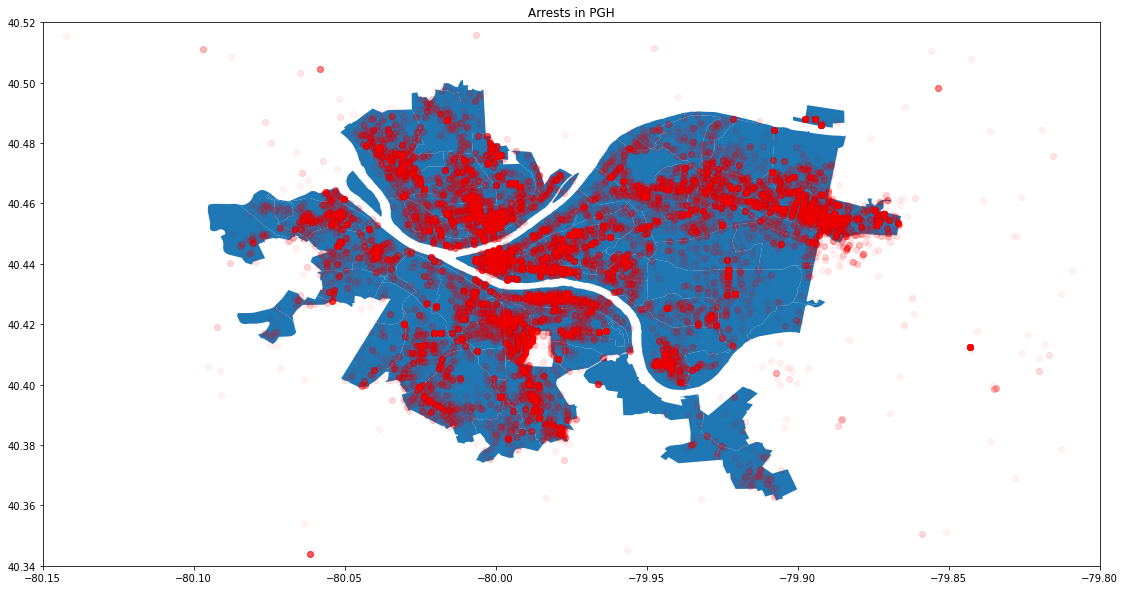

In [71]:
# load data from data set
arrests = pd.read_csv("https://data.wprdc.org/datastore/dump/e03a89dd-134a-4ee8-a2bd-62c40aeebc6f") 
#import map of Pittsburgh
#source: https://spcgis-spc.hub.arcgis.com/datasets/city-of-pittsburgh-neighborhoods/explore?location=40.430850%2C-79.979850%2C12.73
pgh = gpd.read_file('Neighborhoods_.shp')
geometry = [Point(xy) for xy in zip(arrests['X'], arrests['Y'])]
geo_df = gpd.GeoDataFrame(arrests, geometry = geometry)
fig, ax = plt.subplots(figsize = (20,10))
pgh.plot(ax=ax)
plt.xlim([-80.15, -79.80])
plt.ylim([40.34,40.52])
ax.set_title('Arrests in PGH')
geo_df.plot(ax=ax, alpha = .05, color='red')
plt.show()

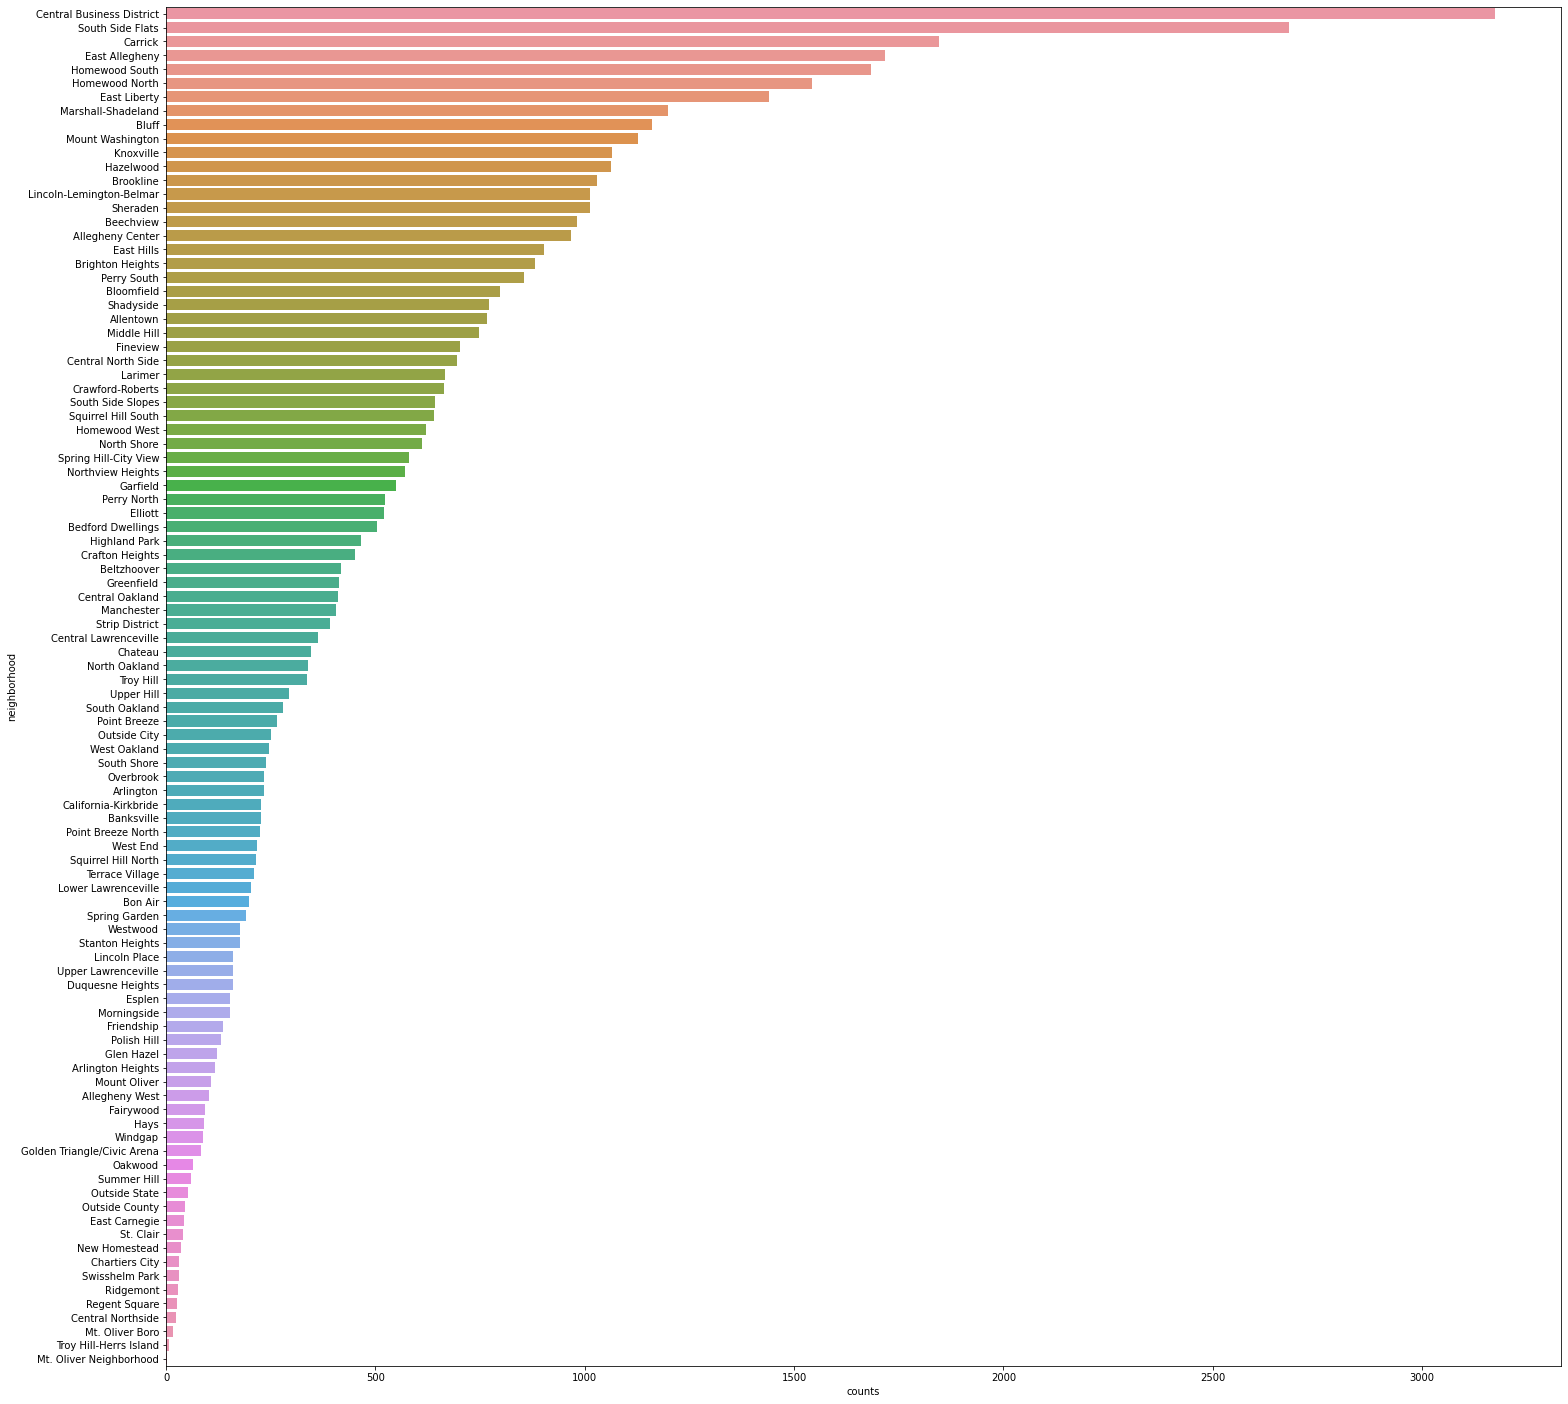

In [72]:
#Count number of crimes in each neighborhood and display as bar chart
tally = arrests['INCIDENTNEIGHBORHOOD'].value_counts().rename_axis('neighborhood').reset_index(name='counts')
tally.sort_values(by='counts', ascending=True)
#print(tally.plot.bar(x='neighborhood', y='counts', figsize=(25,2), width=0.5, position=1, fontsize=14))
fig_dims = (25, 25)
fig, ax = plt.subplots(figsize=fig_dims)

sns.barplot(x = "counts", 
            y = "neighborhood", 
            ax=ax, 
            data=tally, 
            orient="h", 
            order=tally.sort_values('counts', ascending = False).neighborhood)

In [73]:
print("Neighborhood with least amount of arrests: \n ",tally.nsmallest(5, ['counts']))

Neighborhood with least amount of arrests: 
                 neighborhood  counts
97  Mt. Oliver Neighborhood       2
96   Troy Hill-Herrs Island       6
95          Mt. Oliver Boro      17
94        Central Northside      23
93            Regent Square      27


--------------------------------------------------------------------------------------------------------------------------

### Gun Seizures

--------------------------------------------------------------------------------------------------------------------------

### Median Home Values

#### This part of the notebook will show us which neighborhoods have the highest median home value prices in Pittsburgh. 

##### Loading the csv file

In [75]:
# Let's read the csv file
url = 'https://data.wprdc.org/dataset/40188e1c-6d2e-4f20-9391-607bd3054949/resource/9890875b-c1d1-4e64-8fc9-a4a8dc433745/download/housing.csv'
df = pd.read_csv(url)

# Dropping any rows that do not have a home price
df.dropna(inplace=True)

##### Since the data of the home value prices are from 2010, we will need to adjust all the prices for inflation

In [76]:
# Looking at only the median home value column
df.iloc[0:, 21:22].head(5)

,Median Home Value (2010)
1,"$123,600"
2,"$42,200"
3,"$44,200"
5,"$110,900"
6,"$81,100"


##### But first, we need to convert every home value into a floating point number since it is currently of the string data type

In [77]:
# temp_list will carry the converted home values into floating point numbers which will be then added to a new dataframe
temp_list = []

# Getting the home values that are going to be converted
prices = df["Median Home  Value (2010)"]


# Iterating through every value in the column. We are also stripping the "$" and "," characters so it is just the integers
for value in prices.iteritems():
    x = str(value[1])
    x = x.strip('$')
    x = x.replace(',', '')
    temp_list.append(float(x))

    
# Now creating a dictionary that will hold two columns: the list of neighborhoods and its associated median home value price    
d = {'Neighborhood': df["Neighborhood"], 'Median Home Value (2010)': temp_list}


# Creating the data frame that will hold the two columns
home_price_df = pd.DataFrame(data=d)

home_price_df.head() # Prices are now floating point numbers

,Neighborhood,Median Home Value (2010)
1,Allegheny West,123600.0
2,Allentown,42200.0
3,Arlington,44200.0
5,Banksville,110900.0
6,Bedford Dwellings,81100.0


##### Now that we have the median home value prices for each neighborhood in the correct format, we can adjust it for inflation
- The formula for calculating the inflation rate since a given year: CPI in XXXX / CPI in YYYY
- The CPI is the consumer price index which is the price of a weighted average market basket of consumer goods and services purchased by households.
- CPI in 2010: 216.253, CPI in 2021: 279.341
- Source: https://www.in2013dollars.com/Housing/price-inflation/

In [78]:
# 279.341 / 216.253 = 1.292
inflation = 1.292

# For every value in the Home Value column, we are applying a lambda function 
# to it which just multiplies the value by 1.292
home_price_df["Median Home Value (2010)"] = home_price_df["Median Home Value (2010)"].apply(lambda x: x * inflation)


home_price_df.head() # The prices now reflect the median home value in 2021 for each neighborhood in Pittsburgh

,Neighborhood,Median Home Value (2010)
1,Allegheny West,159691.2
2,Allentown,54522.4
3,Arlington,57106.4
5,Banksville,143282.8
6,Bedford Dwellings,104781.2


##### Let's rename the home value column to clarify that it has been adjusted for inflation

In [79]:
home_price_df = home_price_df.rename(columns={"Median Home Value (2010)": "Median Home Value (2010) Adjusted"})
original = home_price_df
home_price_df.head(2)

,Neighborhood,Median Home Value (2010) Adjusted
1,Allegheny West,159691.2
2,Allentown,54522.4


##### Now let's load a map of Pittsburgh. We are going to need to feed it data since it only shows us the layout of the city

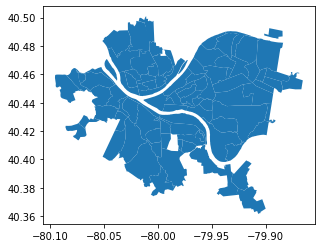

In [80]:
neighborhoods = gpd.read_file('Neighborhoods_.shp') # read in the shapefile
neighborhoods.plot() # plot the geopandas dataframe

##### Now we are merging the data of the home value prices from the home_price_df dataframe to the geopandas dataframe

In [81]:
# Merging the two dataframes
home_value_map = neighborhoods.merge(home_price_df, how='left', left_on='hood', right_on='Neighborhood')

# looking to confirm if it merged correctly
home_value_map[['hood','Median Home Value (2010) Adjusted','geometry']].head()

,hood,Median Home Value (2010) Adjusted,geometry
0,Central Oakland,186500.2,"POLYGON ((-79.95304 40.44203, -79.95302 40.442..."
1,North Oakland,352716.0,"POLYGON ((-79.95455 40.45882, -79.95427 40.458..."
2,West Oakland,78941.2,"POLYGON ((-79.96230 40.44294, -79.96220 40.442..."
3,Crawford-Roberts,122223.2,"POLYGON ((-79.98275 40.44641, -79.98273 40.446..."
4,Strip District,209045.6,"POLYGON ((-79.97494 40.45629, -79.97484 40.456..."


##### Now let's plot the map with our data on it!

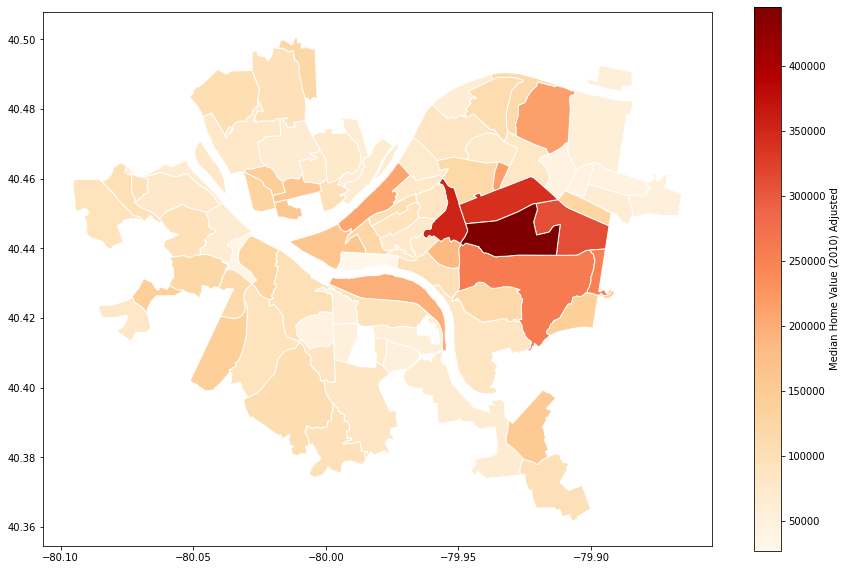

In [82]:
home_value_map.plot(column='Median Home Value (2010) Adjusted', # set the data to be used for coloring
               cmap='OrRd',              # choose a color palette
               edgecolor="white",        # outline the districts in white
               legend=True,              # show the legend
               legend_kwds={'label': "Median Home Value (2010) Adjusted"}, # label the legend
               figsize=(15, 10),         # set the size
               )

##### Now that we can see what areas have the highest median home value, we need to know the names of those neighborhoods

##### Let's make a barplot using seaborn

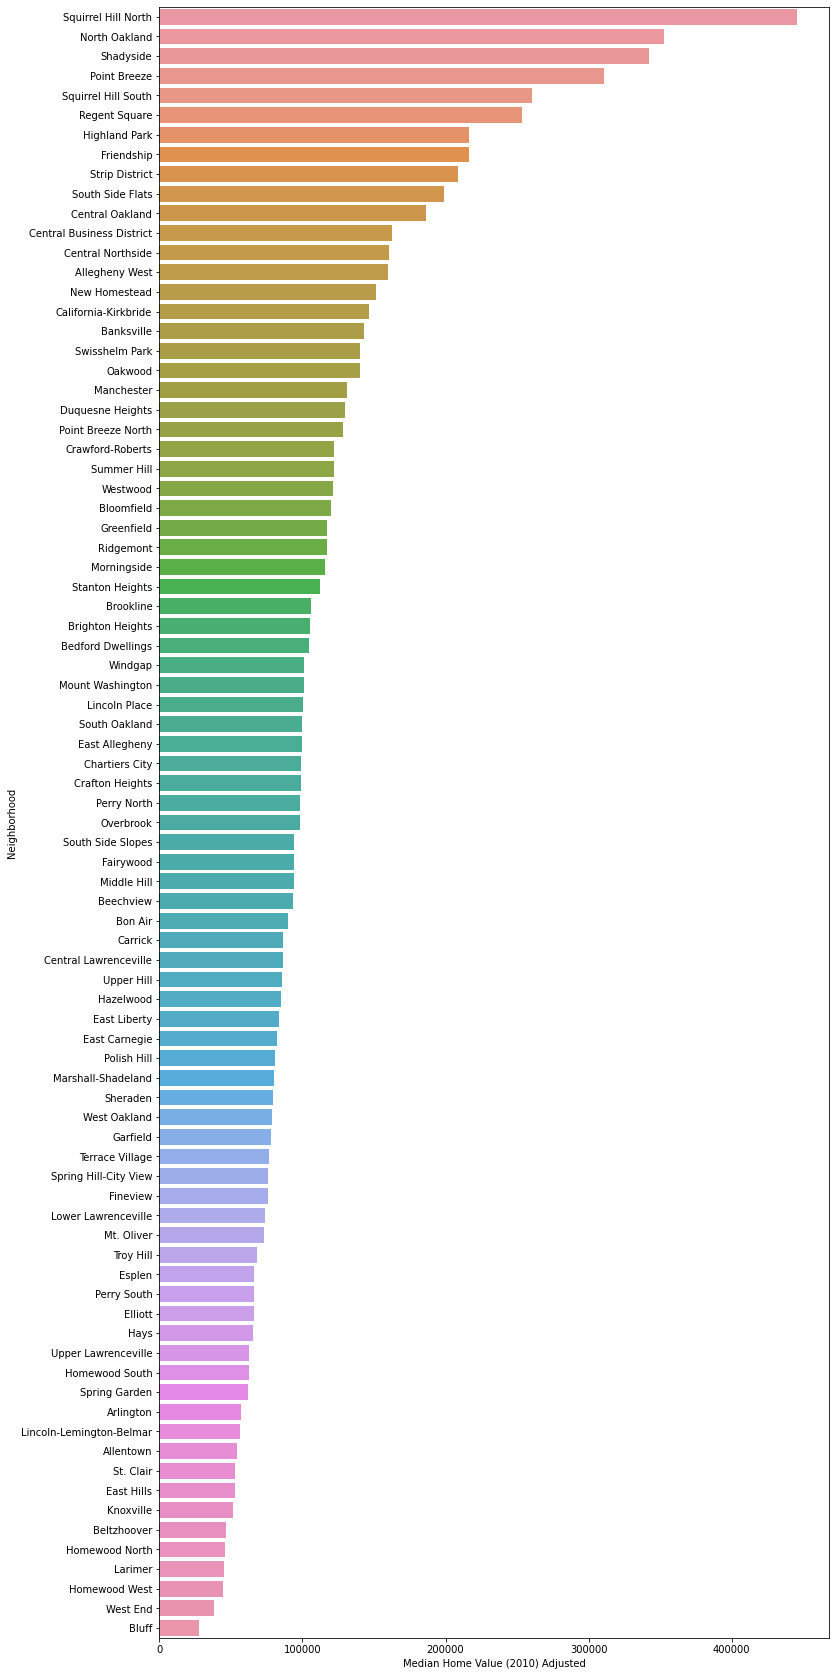

In [83]:
fig_dims = (12, 30)
fig, ax = plt.subplots(figsize=fig_dims)

ax = sns.barplot(x="Median Home Value (2010) Adjusted", # x axis label
                 y="Neighborhood", # y axis label
                 ax=ax, # figsizes
                 data=original, # data we want to show
                 orient="h", # orientation of the graph
                 order=home_price_df.sort_values("Median Home Value (2010) Adjusted", 
                 ascending = False).Neighborhood) # Sorting the values from greatest to least

#### Conclusion:

The median home value of a neighborhood can mean many different things. I will present to you three reasons what a median home value might represent and why it makes a particular neighborhood desirable.

1. Location
 - A high median home value of a particular neighborhood could imply that its location / surroundings are favorable. For example, the houses in the neighborhood are near many businesses, hospitals, schools, and other franchises; this also implies high job availability.
 

2. Condition of the Neighborhood
 - A high median home value can also imply that the condition is desirable. This can mean the neighborhood is clean and the surrounding homes are in good condition; the neighborhood might look appealing. Or a high home value means the neighborhood has a good reputation (example: it might be safe).


3. Houses are Desirable
 - The most obvious reason a neighborhood has a high median home value is because the houses themelves are in good quality, newly built, or renovated. 
 

In [85]:
print("The candidates for the best neighorhood in Pittsburgh are: \n")

home_price_df.sort_values(by='Median Home Value (2010) Adjusted', ascending=False).head(10)

The candidates for the best neighorhood in Pittsburgh are: 



,Neighborhood,Median Home Value (2010) Adjusted
75,Squirrel Hill North,445610.80
55,North Oakland,352716.00
67,Shadyside,342199.12
62,Point Breeze,310467.60
76,Squirrel Hill South,260208.80
65,Regent Square,253619.60
39,Highland Park,216280.80
33,Friendship,216151.60
79,Strip District,209045.60
71,South Side Flats,198645.00


--------------------------------------------------------------------------------------------------------------------------